# Predicting Loan Eligibility with Gradient Boosting

This dataset contains information related to loan applications. When a customer applies for a loan at our company, we rely on statistical models to assess the likelihood of repayment and determine whether the loan should be approved. Because this decision involves numerous complex factors, accurate predictions require sophisticated analysis and modeling.

Our task is to develop a model that predicts whether a loan should be granted to an applicant based on the provided data.

#### Description

In this project, I will work with a dataset containing over 100,000 loan records. The first task is to explore and clean the data to ensure its quality and suitability for analysis. The objective is to identify the most effective approach for predicting whether a loan should be approved for a given applicant.

Once the data has been prepared, I will develop a machine learning model that outputs two key elements: the unique customer ID and a loan status label indicating whether the loan should be granted.

The dataset contains detailed information about customer loans and includes the following fields:

- Loan ID: A unique identifier for each loan.
- Customer ID: A unique identifier for each customer. Note that a customer may have multiple loans.
- Loan Status: A categorical variable indicating whether the loan was approved or not.
- Current Loan Amount: The amount of the previous loan that was either fully repaid or defaulted.
- Term: Indicates whether the loan term is short-term or long-term.
- Credit Score: A numeric score between 0 and 800 representing the creditworthiness of the borrower.
- Years in Current Job: A categorical variable showing how long the customer has held their current job.
- Home Ownership: A categorical variable indicating the customer's housing status—values include "Rent", "Home Mortgage", or "Own" (indicating full home ownership without a mortgage).
- Annual Income: The customer's reported annual income.
- Purpose: The stated purpose of the loan.
- Monthly Debt: The customer’s monthly payments toward existing loans.
- Years of Credit History: The number of years since the customer’s first credit account was opened.
- Months Since Last Delinquent: The number of months since the customer's last delinquent payment.
- Number of Open Accounts: Total number of currently active credit accounts.
- Number of Credit Problems: Total recorded credit issues in the customer’s history.
- Current Credit Balance: The total current debt across all credit sources.
- Maximum Open Credit: The highest credit limit available to the customer across all accounts.
- Bankruptcies: The number of past bankruptcies filed by the customer.
- Tax Liens: The number of tax liens on record.

#### Evaluation Criteria
To successfully pass this task, the machine learning model must achieve an accuracy of at least 70% in predicting whether a loan should be approved.

In [1]:
# Suppress warning messages to keep output clean

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import advanced imputation methods for handling missing data

from fancyimpute import KNN, SoftImpute

In [3]:
# Import essential libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

%matplotlib inline


In [4]:
# Import operator module for functional-style operations

import operator

In [5]:
# Map 'six' to 'sklearn.externals.six' to maintain compatibility with older versions of scikit-learn

import six
import sys
sys.modules['sklearn.externals.six'] = six

In [6]:
# Fix for compatibility: Map deprecated 'sklearn.neighbors.base' to the updated '_base' module

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [7]:
# Patch for deprecated module: Redirect 'sklearn.utils.safe_indexing' to the updated '_safe_indexing'

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

In [8]:
# Import SMOTE to address class imbalance in the dataset

from imblearn.over_sampling import SMOTE

In [9]:
# ================================
# Function: Train and Evaluate a Classifier
# ================================
def classify(est, x, y, X_test, y_test):
    """
    Trains a classifier on the training data and evaluates it on the test set.
    Returns the fitted model, predicted labels, and predicted probabilities.
    """
    est.fit(x, y)  # Fit the model to training data
    y_pred_proba = est.predict_proba(X_test)  # Get predicted probabilities
    y_pred = est.predict(X_test)              # Get predicted labels

    print("Model Evaluation Metrics")
    print("------------------------")
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("F1 Score:", metrics.f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("\nCross-Validation Scores:")
    print(cross_val_score(est, x, y))

    return est, y_pred, y_pred_proba[:, 1]


# ================================
# Function: Compute Feature Importance from a Model
# ================================
def feat_importance(estimator):
    """
    Extracts and ranks feature importance from a fitted tree-based estimator.
    Returns a sorted list of features by importance.
    """
    feature_importance = {
        name: estimator.feature_importances_[index]
        for index, name in enumerate(df_LC.columns)
    }

    # Sort features by importance in descending order
    sorted_importance = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_importance


# ================================
# Function: Train Multiple Models and Compare ROC Curves
# ================================
def run_models(X_train, y_train, X_test, y_test, model_type='Non-balanced'):
    """
    Trains multiple classifiers, evaluates them, and plots ROC curves.
    Returns a performance report and confusion matrices for each model.
    """
    clfs = {
        'GradientBoosting': GradientBoostingClassifier(max_depth=6, n_estimators=100, max_features=0.3),
        'LogisticRegression': LogisticRegression(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
        'XGBClassifier': XGBClassifier()
    }

    metrics_columns = ['model', 'matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score', 'f1_score']
    models_report = pd.DataFrame(columns=metrics_columns)
    conf_matrix = dict()

    # Start ROC plot
    plt.figure(1, figsize=(6, 6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_type}')

    for clf_name, clf in clfs.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1]

        print(f'Computing metrics for {clf_name} ({model_type})')

        tmp = pd.Series({
            'model': clf_name,
            'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
            'roc_auc_score': metrics.roc_auc_score(y_test, y_score),
            'precision_score': metrics.precision_score(y_test, y_pred),
            'recall_score': metrics.recall_score(y_test, y_pred),
            'f1_score': metrics.f1_score(y_test, y_pred)
        })

        models_report = models_report.append(tmp, ignore_index=True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'])

        # ROC curve
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score, drop_intermediate=False, pos_label=1)
        plt.plot(fpr, tpr, label=clf_name)

    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.legend(loc='lower right', prop={'size': 11})
    plt.grid(True)

    return models_report, conf_matrix


In [10]:
#Importing the dataset
data =pd.read_csv("C:/Users/temit/Desktop/My_GitHub/Loan Eligibility Prediction using Gradient Boosting Classifier/LoansTrainingSetV2.csv")

In [11]:
data.head()
len(data)

111107

In [12]:
##Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)

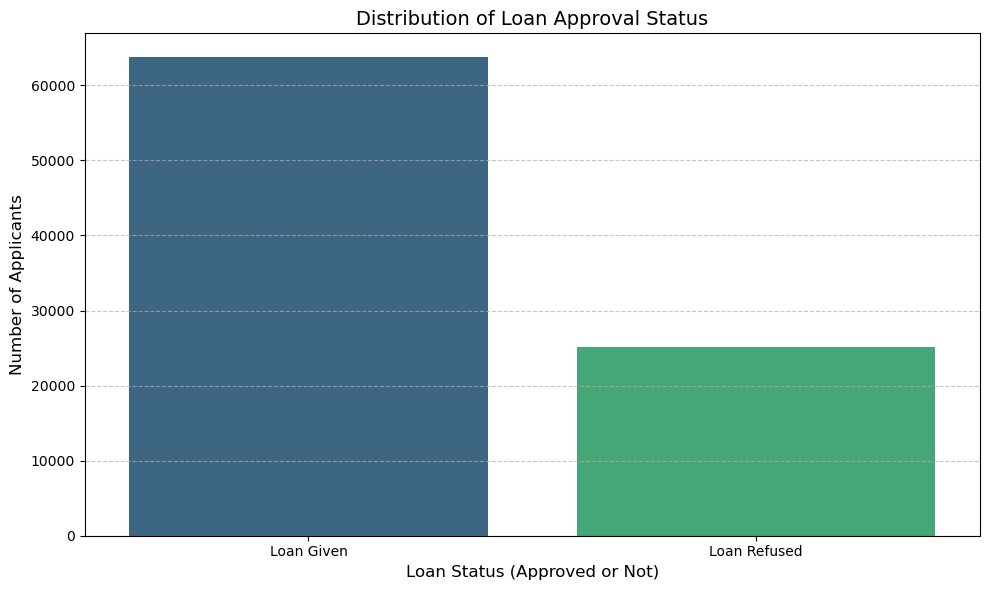

In [13]:
#### PLotting the loan status 

# Count the occurrences of each loan status
loan_status_counts = data["Loan Status"].value_counts()

# Plotting the distribution of loan statuses
plt.figure(figsize=(10,6))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="viridis")
plt.title('Distribution of Loan Approval Status', fontsize=14)
plt.xlabel('Loan Status (Approved or Not)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("1_Distribution of Loan Approval Status.png", dpi=300)
plt.show()

Summary Statistics for Current Loan Amount:
count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64


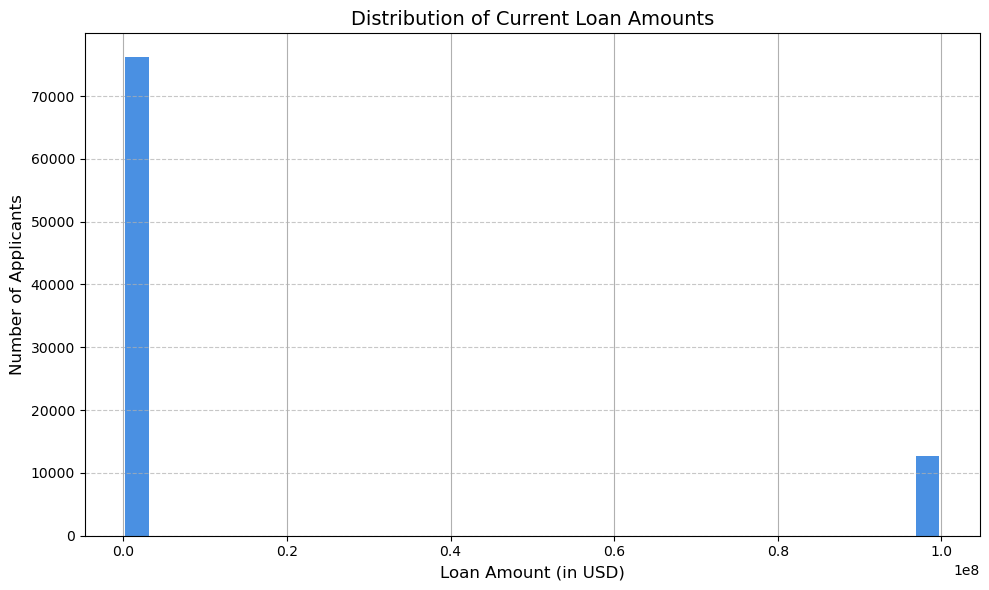

In [14]:
###Current Loan Amount ############

# Summary statistics for Current Loan Amount
print("Summary Statistics for Current Loan Amount:")
print(data["Current Loan Amount"].describe())

# Plotting the distribution of Current Loan Amount
plt.figure(figsize=(10,6))
data["Current Loan Amount"].plot.hist(
    bins=30,
    rwidth=0.85,
    color='#4a90e2',
    grid=True
)

plt.title('Distribution of Current Loan Amounts', fontsize=14)
plt.xlabel('Loan Amount (in USD)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("2_Distribution of Current Loan Amounts.png", dpi=300)
plt.show()

In [15]:
#Finding IQR's for outlier removal

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [16]:
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]


5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [17]:
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()


Summary Statistics for Cleaned Current Loan Amount:
count    76172.000000
mean     13933.915756
std       8235.921922
min        491.000000
25%       7810.000000
50%      12038.000000
75%      19351.000000
max      35875.000000
Name: Current Loan Amount_temp, dtype: float64


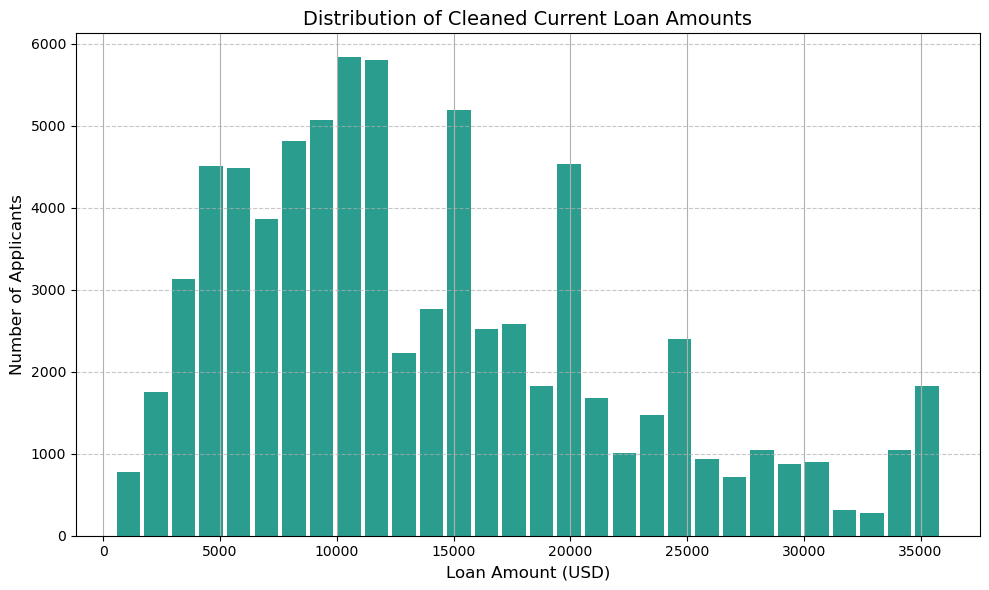

In [18]:
# Clean and convert 'Current Loan Amount_temp' to integer
loan_amount_cleaned = data["Current Loan Amount_temp"]
loan_amount_cleaned = loan_amount_cleaned[loan_amount_cleaned != 'NaN'].astype(int)

# Summary statistics
print("Summary Statistics for Cleaned Current Loan Amount:")
print(loan_amount_cleaned.describe())

# Plotting histogram
plt.figure(figsize=(10,6))
loan_amount_cleaned.plot.hist(
    bins=30,
    rwidth=0.85,
    color='#2a9d8f',
    grid=True
)

plt.title('Distribution of Cleaned Current Loan Amounts', fontsize=14)
plt.xlabel('Loan Amount (USD)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("3_Distribution of Cleaned Current Loan Amounts.png", dpi=300)
plt.show()


In [19]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

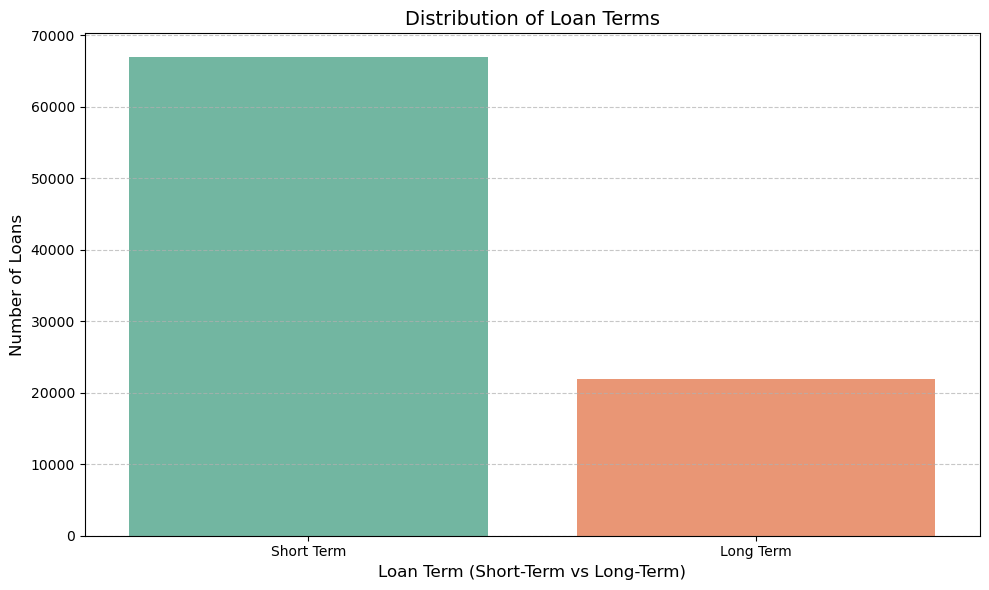

In [20]:
### Visualizing the Distribution of Loan Terms (Short-Term vs Long-Term)

# Count the number of loans by term
loan_term_counts = data["Term"].value_counts()

# Plotting the distribution of loan terms
plt.figure(figsize=(10,6))
sns.barplot(x=loan_term_counts.index, y=loan_term_counts.values, palette="Set2")

plt.title('Distribution of Loan Terms', fontsize=14)
plt.xlabel('Loan Term (Short-Term vs Long-Term)', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("4_Distribution of Loan Terms.png", dpi=300)
plt.show()


In [21]:
#####Credit Score#############

##Max is 7510. It should be between 0-800

data["Credit Score"].describe()

count    67572.000000
mean      1199.199580
std       1680.813805
min        585.000000
25%        714.000000
50%        733.000000
75%        744.000000
max       7510.000000
Name: Credit Score, dtype: float64

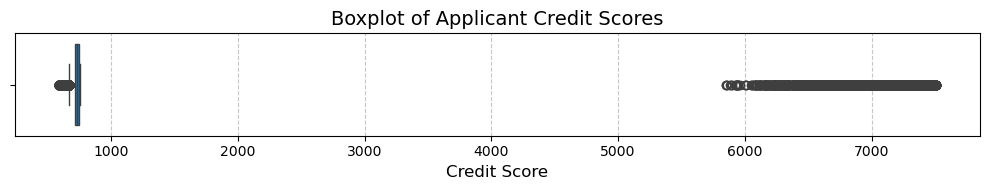

In [22]:

# Set figure size
plt.figure(figsize=(10, 2))

# Plotting the distribution of credit scores using a boxplot
sns.boxplot(x=data["Credit Score"], color="#1f77b4")

plt.title('Boxplot of Applicant Credit Scores', fontsize=14)
plt.xlabel('Credit Score', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("5_Boxplot of Applicant Credit Scores.png", dpi=300)
plt.show()


In [23]:
data["Credit Score"].isnull().sum()


21338

In [24]:
#Normalizing Abnormally High Credit Scores Above 800

data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])


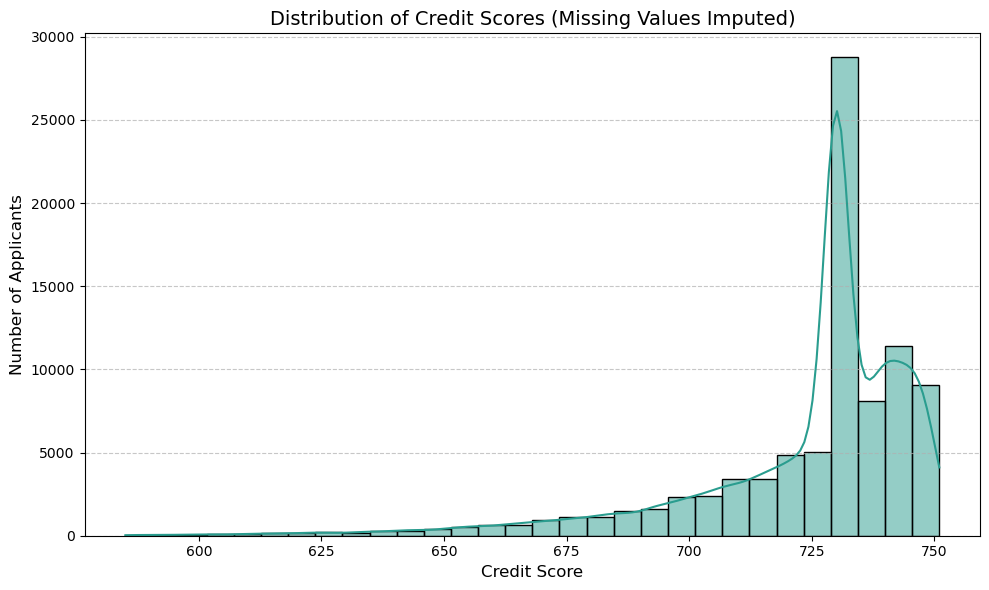

In [25]:
#  Imputing Missing Credit Scores with Median and Visualizing the Distribution

# Compute median credit score (excluding NaNs)
median_score = data["Credit Score"].median()

# Fill missing credit scores with the median
data["Credit Score_Filled"] = data["Credit Score"].fillna(median_score)

# Plot the distribution of filled credit scores
plt.figure(figsize=(10,6))
sns.histplot(data["Credit Score_Filled"], kde=True, bins=30, color='#2a9d8f')

plt.title('Distribution of Credit Scores (Missing Values Imputed)', fontsize=14)
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("6_Distribution of Credit Scores (Missing Values Imputed).png", dpi=300)
plt.show()


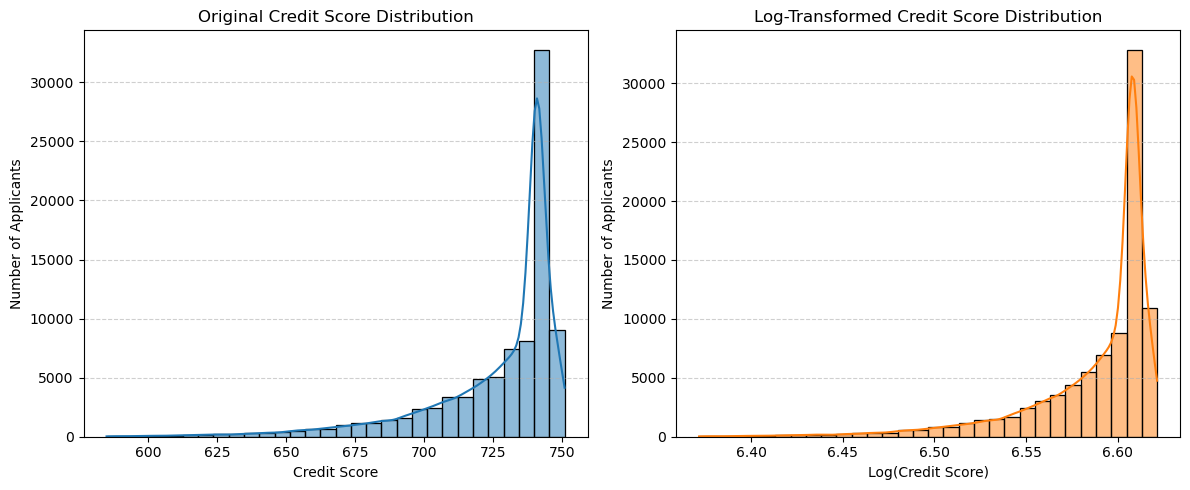

In [26]:
#As we can see this data is skewed so when we replace it with median it is giving us problems. 
#Replacing with 75th percentile and taking log we get a better distribution


# Impute missing credit scores with a chosen value (e.g., 741 based on domain knowledge or median)
data["Credit Score"].fillna(741, inplace=True)

# Plotting the distribution of credit scores
plt.figure(figsize=(12, 5))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(data["Credit Score"], kde=True, bins=30, color='#1f77b4')
plt.title('Original Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Applicants')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Log-transformed distribution (for normalization)
plt.subplot(1, 2, 2)
sns.histplot(np.log(data["Credit Score"]), kde=True, bins=30, color='#ff7f0e')
plt.title('Log-Transformed Credit Score Distribution')
plt.xlabel('Log(Credit Score)')
plt.ylabel('Number of Applicants')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("7_", dpi=300)
plt.show()

In [27]:
data['Home Ownership'].unique()
#As we can see it has Home Mortgage and haveMortgage as 2 different classes. Lets fix that


array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [28]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

data['Home Ownership'].unique()


array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [29]:
##################Annual Income######################
data['Annual Income'].describe()


count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [30]:
##Lets look at the quantiles of this columns

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [31]:
#As we can see they lie in the 99th percentile of the data. Lets replace them

# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287


data['Annual Income'].isna().sum()
#So we have about 21000 null values 

##We will impute the mising data with other columns towards the end


21338

In [32]:
#### Standardizing Loan Purpose Categories

data['Purpose'].value_counts()
#So other and Other mean the same thing. Lets make it the same


Purpose
Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: count, dtype: int64

In [33]:
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

In [34]:
#### Standardizing Monthly debt Categories


data['Monthly Debt'].describe()
##So this is not numeric column. Lets explore


count     88910
unique    76609
top           0
freq         55
Name: Monthly Debt, dtype: object

In [35]:
data['Monthly Debt'] 
# But this should be a numeric column. So lets convert it to float


0         777.39
1         892.09
2        1244.02
3         990.94
4         503.71
          ...   
88905     567.62
88906    2508.63
88907      818.2
88908     360.17
88909     749.13
Name: Monthly Debt, Length: 88910, dtype: object

In [36]:
#pd.to_numeric(data['Monthly Debt'] )
#As we can see there is a $ symbol present. Lets replace it 


In [37]:
data['Monthly Debt'].unique()

array(['777.39', '892.09', '1244.02', ..., 2508.63, 818.2, 360.17],
      dtype=object)

In [38]:
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '')


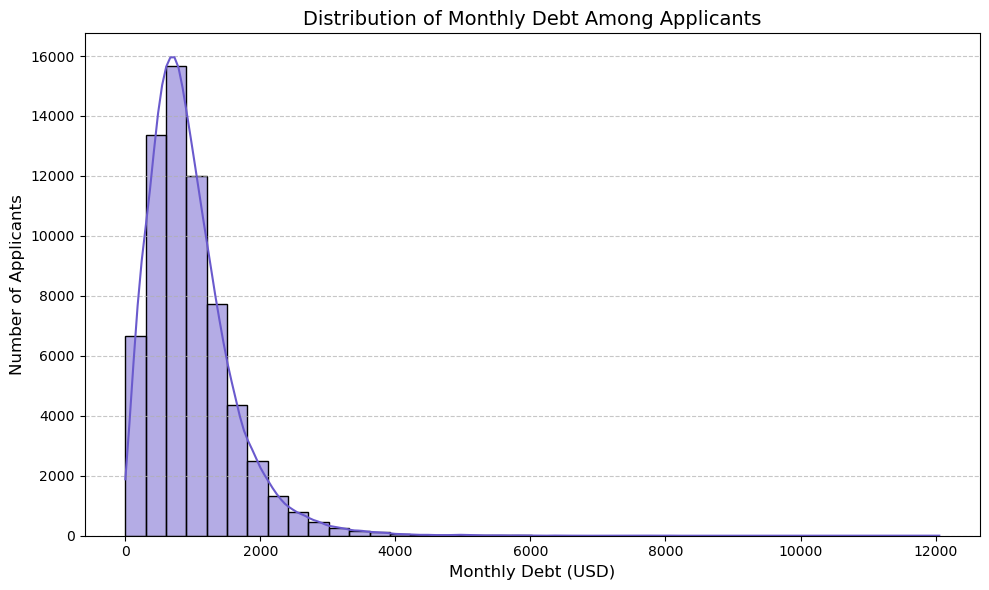

In [39]:
# Convert 'Monthly Debt' to numeric, coercing errors to NaN (if any)
data['Monthly Debt'] = pd.to_numeric(data['Monthly Debt'], errors='coerce')

# Drop or fill missing values if necessary (optional)
# data['Monthly Debt'].fillna(data['Monthly Debt'].median(), inplace=True)

# Plot the distribution of Monthly Debt
plt.figure(figsize=(10,6))
sns.histplot(data['Monthly Debt'], bins=40, kde=True, color='#6a5acd')

plt.title('Distribution of Monthly Debt Among Applicants', fontsize=14)
plt.xlabel('Monthly Debt (USD)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("8_Distribution of Monthly Debt Among Applicants.png", dpi=300)
plt.show()

In [40]:
#We can see that there are outliers in this data because of the plot
#Lets explore

data['Monthly Debt'].describe()
#The max value is too high here


count    65536.000000
mean       962.406632
std        632.799593
min          0.000000
25%        532.250000
50%        843.770000
75%       1251.342500
max      12055.680000
Name: Monthly Debt, dtype: float64

In [41]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])


0.200     464.21000
0.750    1251.34250
0.900    1740.35000
0.950    2112.21000
0.990    3084.08600
0.999    4927.21625
Name: Monthly Debt, dtype: float64

In [42]:
#Problem is with 99th percentile. lets dig deeper

data['Monthly Debt'].quantile([0.9995,.9999])
#So problem again is wit 99th percentile


0.9995    5513.352425
0.9999    7719.187600
Name: Monthly Debt, dtype: float64

In [43]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330


0.99970     5979.063765
0.99999    11253.511940
Name: Monthly Debt, dtype: float64

In [44]:
data['Monthly Debt'].quantile([0.999,1])


0.999     4927.21625
1.000    12055.68000
Name: Monthly Debt, dtype: float64

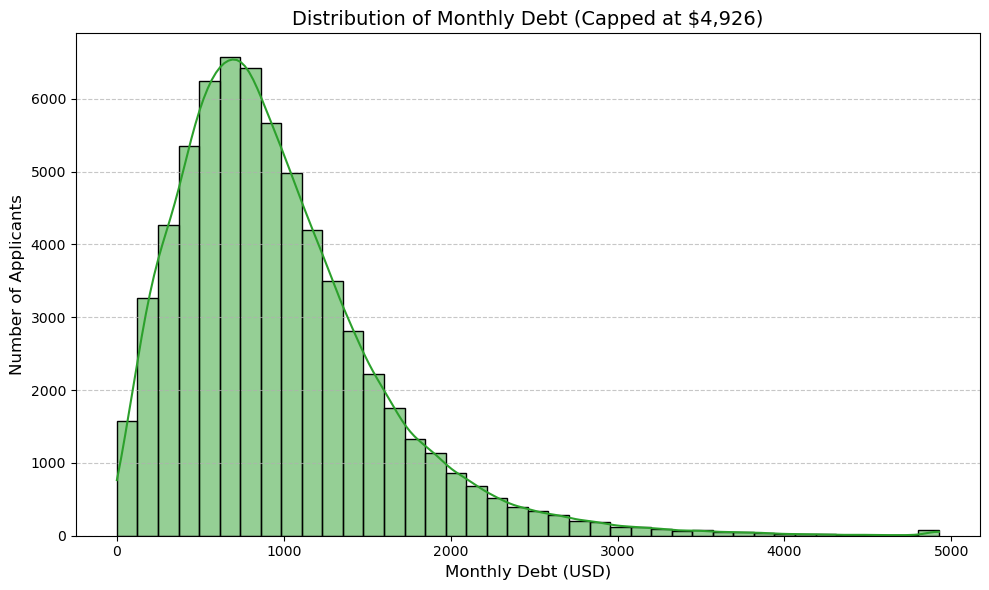

In [45]:
#Need to replace this

# Cap extreme monthly debt values to reduce skewness (based on domain or IQR analysis)
monthly_debt_cap = 4926
data['Monthly Debt'] = data['Monthly Debt'].apply(lambda x: min(x, monthly_debt_cap))

# Plotting the capped Monthly Debt distribution
plt.figure(figsize=(10,6))
sns.histplot(data["Monthly Debt"], bins=40, kde=True, color="#2ca02c")

plt.title('Distribution of Monthly Debt (Capped at $4,926)', fontsize=14)
plt.xlabel('Monthly Debt (USD)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("9_Distribution of Monthly Debt.png", dpi=300)
plt.show()
#Now we get the right distribution


Value Counts for Years of Credit History:
Years of Credit History
3.6     1
3.7     1
3.8     2
3.9     2
4.0     5
       ..
59.9    1
60.5    2
62.5    1
65.0    1
70.5    1
Name: count, Length: 508, dtype: int64


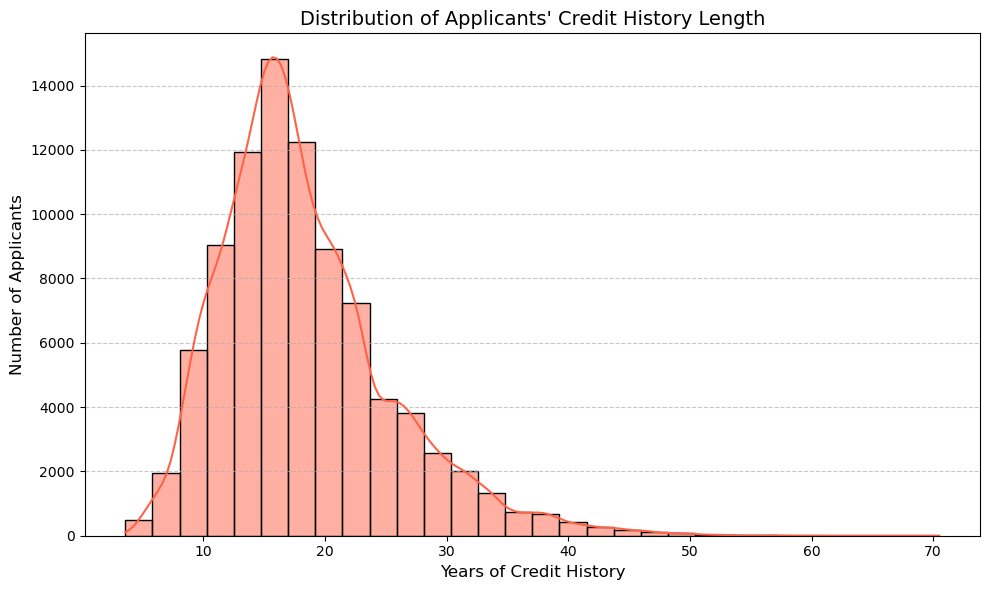

In [46]:
####################Years of credit history #################

# View frequency counts
print("Value Counts for Years of Credit History:")
print(data['Years of Credit History'].value_counts().sort_index())

# Plotting the distribution
plt.figure(figsize=(10,6))
sns.histplot(data["Years of Credit History"], bins=30, kde=True, color='#ff6347')

plt.title('Distribution of Applicants\' Credit History Length', fontsize=14)
plt.xlabel('Years of Credit History', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("10_Credit History Length.png", dpi=300)
plt.show()
#Over all looks pretty clean! no need of doing anything


In [47]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()


count    40404.000000
mean        35.080289
std         22.008583
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [48]:
#Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()
#We have nearly 48506 NA;s. We will try to handle them at last 


48506

In [49]:
##############Number of open accounts ##############

data['Number of Open Accounts'].describe()
#The max number seems odd. Lets investigate


count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

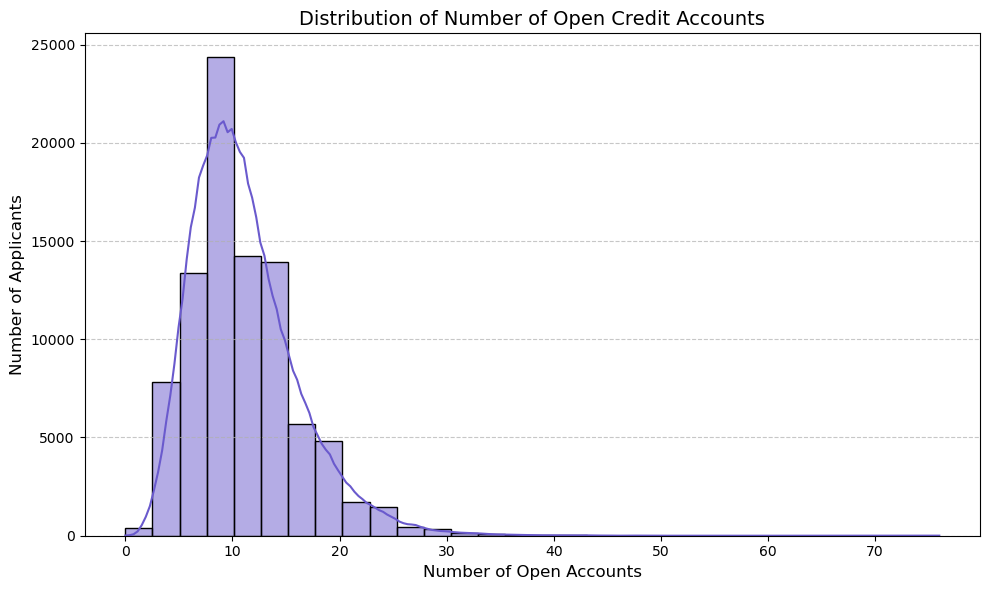

In [50]:
# Plotting the distribution of Number of Open Accounts
plt.figure(figsize=(10,6))
sns.histplot(data['Number of Open Accounts'], bins=30, kde=True, color='#6a5acd')

plt.title('Distribution of Number of Open Credit Accounts', fontsize=14)
plt.xlabel('Number of Open Accounts', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("11_Number of Applicants.png", dpi=300)
plt.show()
#Yes there are outliers in this columns. Let dig deeper


In [51]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Ok so replacing anything greater than 99th percentile with 99th percentile values


0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

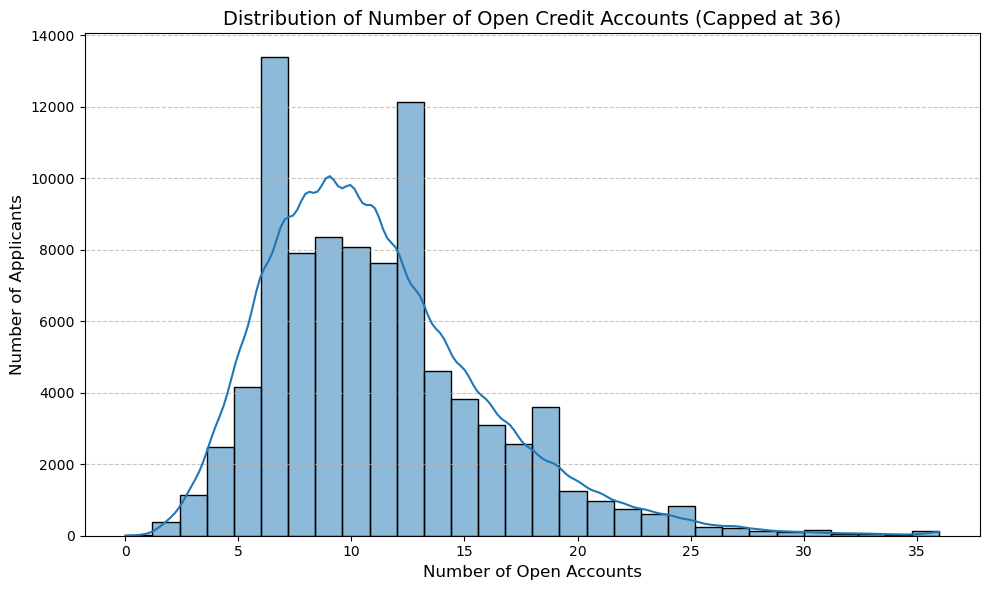

In [52]:
# Cap extreme values in 'Number of Open Accounts' to reduce outlier impact
max_open_accounts = 36
data['Number of Open Accounts'] = data['Number of Open Accounts'].apply(lambda x: min(x, max_open_accounts))

# Plot the capped distribution
plt.figure(figsize=(10,6))
sns.histplot(data['Number of Open Accounts'], bins=30, kde=True, color='#1f77b4')

plt.title('Distribution of Number of Open Credit Accounts (Capped at 36)', fontsize=14)
plt.xlabel('Number of Open Accounts', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("12_.png", dpi=300)
plt.show()
#Looks good now


Summary Statistics for Number of Credit Problems:
count    88910.000000
mean         0.160477
std          0.473746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64


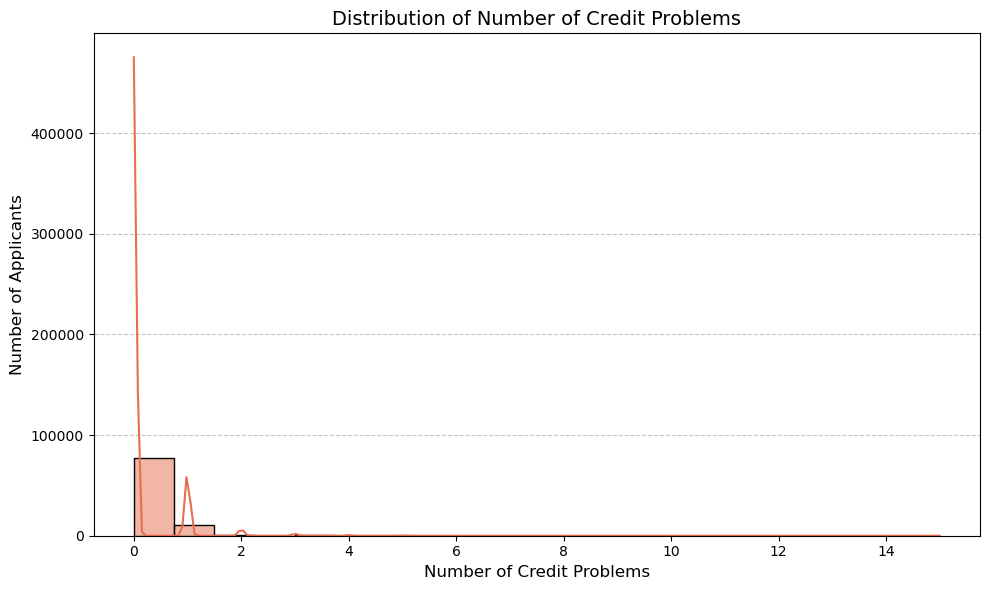

In [53]:

#######################Number of Credit problems##############

# Summary statistics for 'Number of Credit Problems'
print("Summary Statistics for Number of Credit Problems:")
print(data['Number of Credit Problems'].describe())

# Plotting the distribution of credit problems
plt.figure(figsize=(10,6))
sns.histplot(data['Number of Credit Problems'], bins=20, kde=True, color='#e76f51')

plt.title('Distribution of Number of Credit Problems', fontsize=14)
plt.xlabel('Number of Credit Problems', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("13_.png", dpi=300)
plt.show()

In [54]:
#Okay lets look at value _counts


data['Number of Credit Problems'].value_counts()

#Okay looks good


Number of Credit Problems
0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: count, dtype: int64

Summary Statistics for Current Credit Balance:
count    8.891000e+04
mean     1.543593e+04
std      1.965873e+04
min      0.000000e+00
25%      5.949000e+03
50%      1.103900e+04
75%      1.930100e+04
max      1.730472e+06
Name: Current Credit Balance, dtype: float64


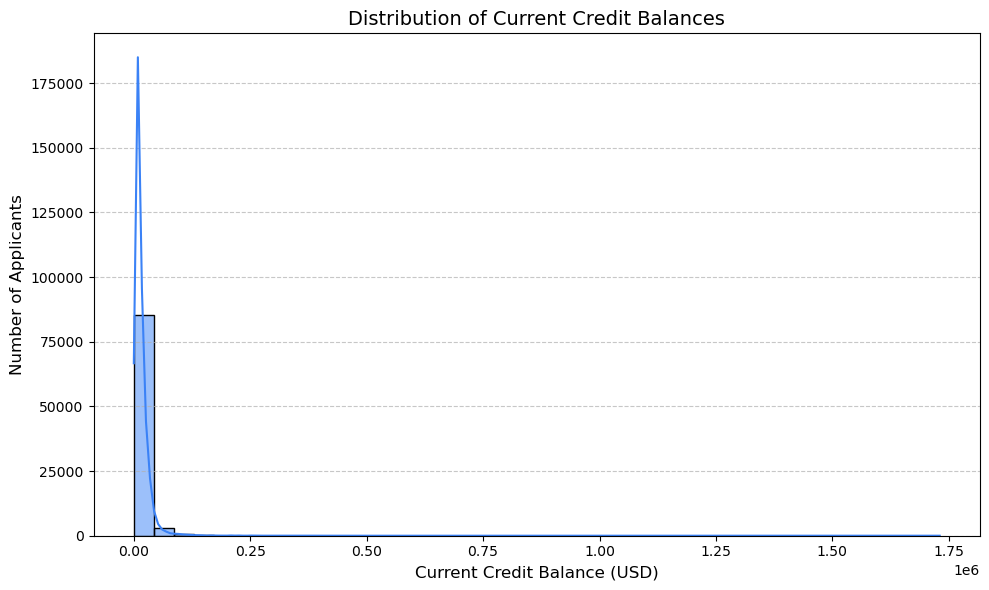

In [55]:
##################Current Credit Balance###########

# Summary statistics for Current Credit Balance
print("Summary Statistics for Current Credit Balance:")
print(data['Current Credit Balance'].describe())

# Plotting the distribution of Current Credit Balance
plt.figure(figsize=(10,6))
sns.histplot(data['Current Credit Balance'], bins=40, kde=True, color='#3b82f6')

plt.title('Distribution of Current Credit Balances', fontsize=14)
plt.xlabel('Current Credit Balance (USD)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("14_.png", dpi=300)
plt.show()
#It seems there are outliers in this data. Lets investigate


In [56]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])


0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [57]:
#lets dig deeper

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

In [58]:
#So lets replace it with 95th percentile

data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])


0.55      12295.00
0.76      19805.84
0.87      27525.66
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

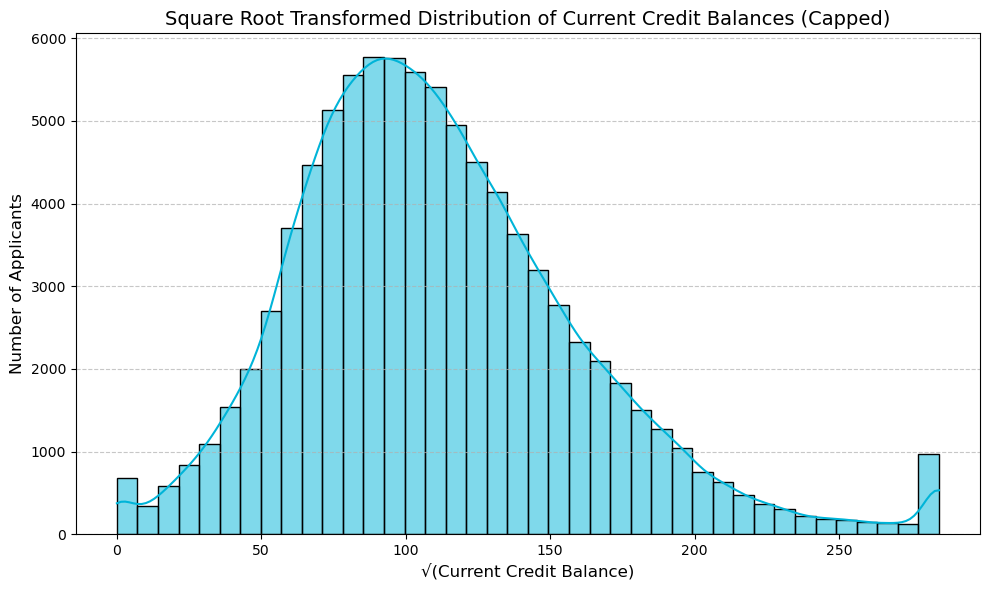

In [59]:
# Cap high outliers in 'Current Credit Balance' to reduce skewness
credit_balance_cap = 81007
data['Current Credit Balance'] = data['Current Credit Balance'].apply(lambda x: min(x, credit_balance_cap))

# Apply square root transformation to reduce skewness
credit_balance_sqrt = np.sqrt(data['Current Credit Balance'])

# Plot the transformed distribution
plt.figure(figsize=(10,6))
sns.histplot(credit_balance_sqrt, bins=40, kde=True, color='#00b4d8')

plt.title('Square Root Transformed Distribution of Current Credit Balances (Capped)', fontsize=14)
plt.xlabel('√(Current Credit Balance)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("15_.png", dpi=300)
plt.show()
#The plot doesnt look good. We need to transform it


In [60]:
data['Current Credit Balance']=data['Current Credit Balance']**(1/2)


In [61]:
#######################Max open credit################

data['Maximum Open Credit'].describe()


count     88910
unique    58216
top           0
freq        450
Name: Maximum Open Credit, dtype: object

In [62]:
data['Maximum Open Credit'].value_counts()


Maximum Open Credit
0         450
0         160
15847       9
17464       9
6827        8
         ... 
28296       1
10199       1
132602      1
10395       1
21124       1
Name: count, Length: 58216, dtype: int64

In [63]:
#sns.distplot(data['Maximum Open Credit'])
#So there are some str characters present in the data. Lets find them
#could not convert string to float: '#VALUE!'


In [64]:
#pd.to_numeric(data['Maximum Open Credit'])
#Unable to parse string "#VALUE!" at position 4930

In [65]:
#Lets replace #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)


In [66]:
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])


In [67]:
data['Maximum Open Credit'].isnull().sum()
#Now we have only 2 Nan;s in the data. Lets replace them with mean  


2

In [68]:
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)


In [69]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])



0.55       24037.95
0.76       37259.84
0.87       50736.66
0.98      114682.56
0.99      171423.91
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [70]:
#Lets replace the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423


In [71]:
###############Bankruptcies##########
data['Bankruptcies'].describe()


count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [72]:
data['Bankruptcies'].value_counts()


Bankruptcies
0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: count, dtype: int64

In [73]:
data['Bankruptcies'].unique()

#So we have Nan's. Lets fill them with median


array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [74]:
data['Bankruptcies']=data['Bankruptcies'].fillna(3)


In [75]:
####Tax Liens######

data['Tax Liens'].describe()


count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [76]:
data['Tax Liens'].value_counts()



Tax Liens
0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: count, dtype: int64

In [77]:
data['Bankruptcies'].unique()
###Looks good

array([0., 1., 3., 2., 4., 5., 7., 6.])

In [78]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [79]:
#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)
#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23092221.868378
[SoftImpute] Iter 1: observed MAE=261.480152 rank=3
[SoftImpute] Iter 2: observed MAE=258.548469 rank=3
[SoftImpute] Iter 3: observed MAE=258.207662 rank=3
[SoftImpute] Iter 4: observed MAE=258.184852 rank=3
[SoftImpute] Iter 5: observed MAE=258.204643 rank=3
[SoftImpute] Iter 6: observed MAE=258.230069 rank=3
[SoftImpute] Iter 7: observed MAE=258.255573 rank=3
[SoftImpute] Iter 8: observed MAE=258.280106 rank=3
[SoftImpute] Iter 9: observed MAE=258.303449 rank=3
[SoftImpute] Iter 10: observed MAE=258.325504 rank=3
[SoftImpute] Iter 11: observed MAE=258.346214 rank=3
[SoftImpute] Iter 12: observed MAE=258.365509 rank=3
[SoftImpute] Iter 13: observed MAE=258.383517 rank=3
[SoftImpute] Iter 14: observed MAE=258.400220 rank=3
[SoftImpute] Iter 15: observed MAE=258.415645 rank=3
[SoftImpute] Iter 16: observed MAE=258.429899 rank=3
[SoftImpute] Iter 17: observed MAE=258.443135 rank=3
[SoftImpute] Iter 18: observed MAE=258.455321 ra

In [80]:

#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)


[[-0.1869176  -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958408]
 [ 1.48349848  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958408]
 [ 0.32079375 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958408]
 ...
 [ 1.40247376 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958408]
 [-1.1281112  -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958408]
 [ 0.62515919 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361205]]
   
(88910, 16)


In [81]:
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

Model Evaluation Metrics
------------------------
Accuracy: 0.7275522063509916
ROC AUC Score: 0.7410384698407799
F1 Score: 0.3881451545002947

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     18981
           1       0.55      0.30      0.39      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.60      0.61     26673
weighted avg       0.70      0.73      0.70     26673


Cross-Validation Scores:
[0.7316838  0.73353149 0.73158191 0.73600064 0.72611874]
XGBoost Feature Importances:
[0.16540836 0.24333777 0.13646878 0.03076099 0.04676722 0.04874518
 0.03079534 0.03333562 0.03167249 0.02943049 0.02917567 0.03203659
 0.03305165 0.03669776 0.03586981 0.03644621]


<Figure size 1200x600 with 0 Axes>

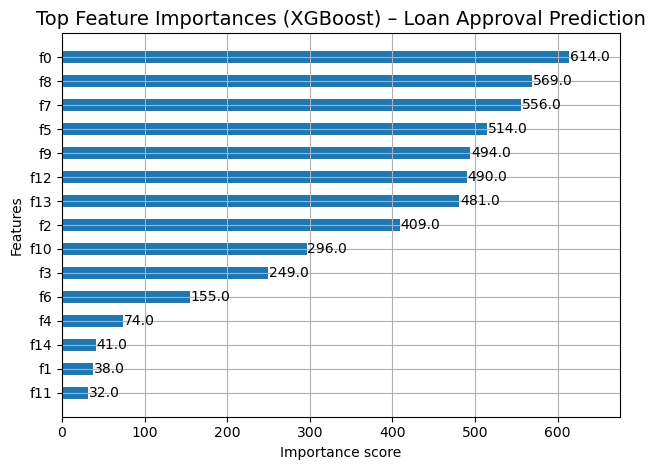

In [82]:
#Finding accuracy and feature importance using XGB classifier
# Train and evaluate the XGBoost classifier
xgb_model, y_pred_train, y_pred_test = classify(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
    X_train, y_train, 
    X_test, y_test
)

# Display feature importances
print("XGBoost Feature Importances:")
print(xgb_model.feature_importances_)

# Plot feature importances
plt.figure(figsize=(12, 6))
plot_importance(xgb_model, max_num_features=15, importance_type='weight', height=0.5, grid=True)
plt.title('Top Feature Importances (XGBoost) – Loan Approval Prediction', fontsize=14)
plt.tight_layout()
plt.savefig("16_.png", dpi=300)
plt.show()

# Extract sorted feature importance (if feat_importance is a custom function)
feat1 = feat_importance(xgb_model)


In [83]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

Model Evaluation Metrics
------------------------
Accuracy: 0.7115809995126158
ROC AUC Score: 0.7394839655869572
F1 Score: 0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     18981
           1       0.00      0.00      0.00      7692

    accuracy                           0.71     26673
   macro avg       0.36      0.50      0.42     26673
weighted avg       0.51      0.71      0.59     26673


Cross-Validation Scores:
[0.71923201 0.71915167 0.71912911 0.71937013 0.71937013]


In [84]:
#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)


Model Evaluation Metrics
------------------------
Accuracy: 0.6839500618603082
ROC AUC Score: 0.6073078340129547
F1 Score: 0.3099214145383104

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18981
           1       0.42      0.25      0.31      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.65      0.68      0.66     26673


Cross-Validation Scores:
[0.69368573 0.69705977 0.69783884 0.69141159 0.68747489]


In [85]:
########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Model Evaluation Metrics
------------------------
Accuracy: 0.7201289693697747
ROC AUC Score: 0.672272533912789
F1 Score: 0.21197086456244063

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.65      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673


Cross-Validation Scores:
[0.72622108 0.72927378 0.7282076  0.72836828 0.72684181]


In [86]:
########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Model Evaluation Metrics
------------------------
Accuracy: 0.6503205488696434
ROC AUC Score: 0.5784404673168119
F1 Score: 0.4026132069429322

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75     18981
           1       0.40      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.65      0.65      0.65     26673


Cross-Validation Scores:
[0.65287596 0.6590617  0.65815056 0.65807022 0.65453523]


In [87]:
## Compare Multiple Models

def run_models(X_train, y_train, X_test, y_test, model_type='Non-balanced', plot_roc=True):
    classifiers = {
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'KNeighbors': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(),
        'DecisionTree': DecisionTreeClassifier()
    }

    models_report = []
    conf_matrix = {}
    plt.figure(figsize=(10, 7))

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else y_pred

        # ROC Curve
        if plot_roc:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{clf_name} (AUC = {roc_auc:.2f})')

        metrics_dict = {
            'Model': clf_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_score)
        }

        models_report.append(metrics_dict)
        conf_matrix[clf_name] = confusion_matrix(y_test, y_pred)

    if plot_roc:
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Non-balanced Data)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.savefig("17_.png", dpi=300)
        plt.show()

    return pd.DataFrame(models_report), conf_matrix


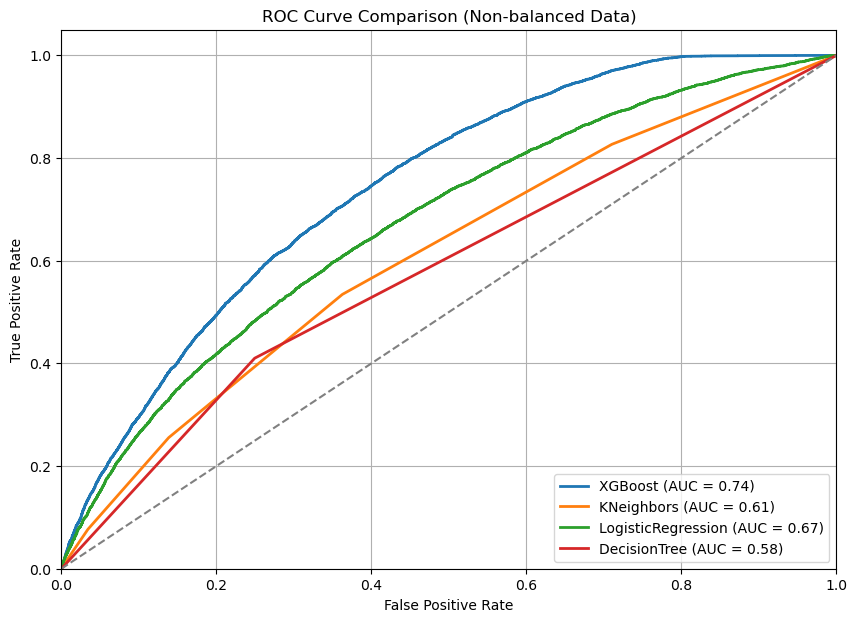

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.728864,0.544508,0.289290,0.377839,0.742520
1,KNeighbors,0.689011,0.423178,0.255434,0.318574,0.608414
2,LogisticRegression,0.722491,0.554031,0.127651,0.207495,0.672401
3,DecisionTree,0.653695,0.395452,0.410091,0.402639,0.580347


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
models_report

In [89]:
###########Synthetically balancing the dataset##################
# 📌 SMOTE-Based Resampling and Model Evaluation – Loan Approval Prediction

# Step 1: Define a clean 50/50 train-test split
split_idx = len(X_scaled) // 2
X_train_raw, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train_raw, y_test = y[:split_idx], y[split_idx:]

# Step 2: Apply SMOTE to balance the training set only
print("🔄 Applying SMOTE to Balance the Training Data...")
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train_raw, y_train_raw)



def run_models(X_train, y_train, X_test, y_test, model_type='Balanced', plot_roc=True):
    classifiers = {
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'KNeighbors': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(),
        'DecisionTree': DecisionTreeClassifier()
    }

    models_report = []
    conf_matrix = {}
    plt.figure(figsize=(10, 7))

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else y_pred

        # ROC Curve
        if plot_roc:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{clf_name} (AUC = {roc_auc:.2f})')

        metrics_dict = {
            'Model': clf_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_score)
        }

        models_report.append(metrics_dict)
        conf_matrix[clf_name] = confusion_matrix(y_test, y_pred)

    if plot_roc:
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison (Balanced Data)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.savefig("18_.png", dpi=300)
        plt.show()

    return pd.DataFrame(models_report), conf_matrix

🔄 Applying SMOTE to Balance the Training Data...


📊 Training and Evaluating Models on Balanced Dataset


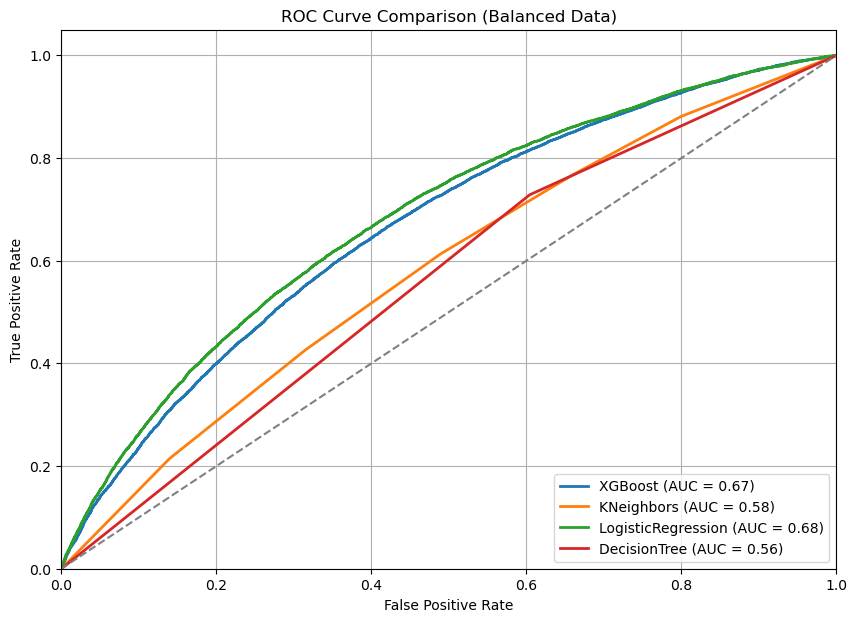

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.489821,0.338429,0.844604,0.483230,0.666380
1,KNeighbors,0.539489,0.330289,0.613620,0.429431,0.583201
2,LogisticRegression,0.664920,0.427429,0.549104,0.480686,0.681833
3,DecisionTree,0.489731,0.321792,0.728395,0.446381,0.562097


In [90]:
# Step 3: Train and Evaluate Models on Balanced Data
print("📊 Training and Evaluating Models on Balanced Dataset")
models_report_bal, conf_matrix_bal = run_models(
    X_train_bal, y_train_bal, 
    X_test, y_test, 
    model_type='Balanced'
)

# Display model performance
models_report_bal

In [91]:
################Now we  know that GBM model performed the best so 
# 🎯 Train and Save Gradient Boosting Model – Loan Approval Prediction

# Define the Gradient Boosting Classifier with optimized hyperparameters
gbm = GradientBoostingClassifier(
    max_depth=6,
    n_estimators=100,
    max_features=0.3,
    random_state=42  # Ensures reproducibility
)

# Train the model on the scaled features and labels
print("📈 Training Gradient Boosting Model...")
gbm.fit(X_scaled, y)

# Save the trained model to disk for future use
model_path = 'C:/Users/temit/Desktop/My_GitHub/Loan Eligibility Prediction using Gradient Boosting Classifier/GBM_Model_version1.pkl'
joblib.dump(gbm, model_path)
print(f"✅ Model saved successfully as: {model_path}")
# load model
#gbm_pickle = joblib.load('GBM_Model_version1.pkl')

📈 Training Gradient Boosting Model...
✅ Model saved successfully as: C:/Users/temit/Desktop/My_GitHub/Loan Eligibility Prediction using Gradient Boosting Classifier/GBM_Model_version1.pkl


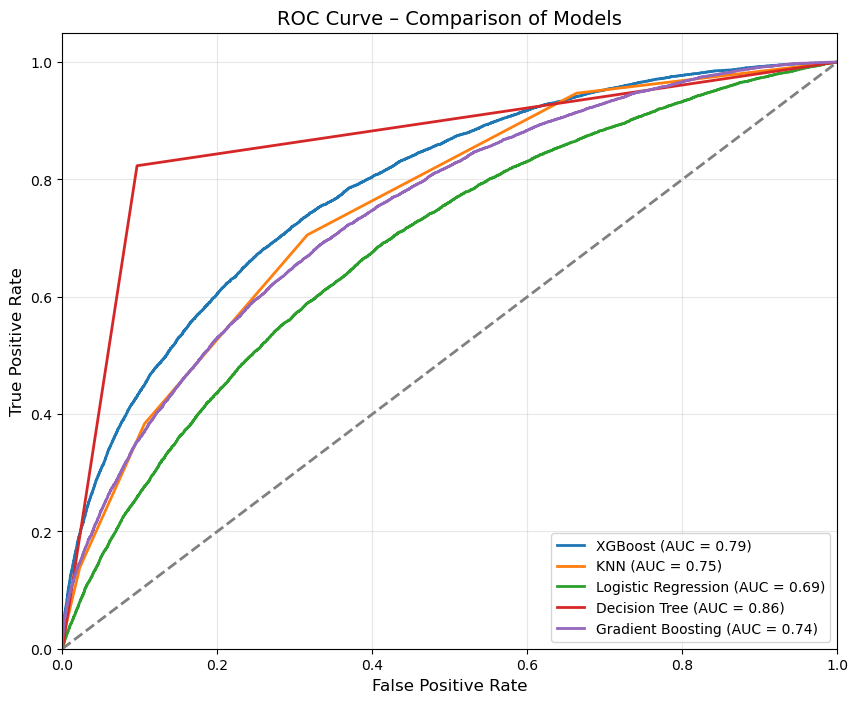

In [92]:
# Example models (already trained)
models = {
    "XGBoost": xgb_model,
    "KNN": knc,
    "Logistic Regression": logit,
    "Decision Tree": dtc,
    "Gradient Boosting": gbm
}

plt.figure(figsize=(10, 8))

# Iterate through models to plot ROC curves
for name, model in models.items():
    # Get predicted probabilities for the positive class
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:  # Some models like SVM might use decision_function
        y_proba = model.decision_function(X_test)

    # Calculate FPR and TPR
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – Comparison of Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.savefig("17_.png", dpi=300, bbox_inches='tight')
plt.show()